In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils.pickle_helper import *
from utils.csv_helper import *
from utils.onehot_helper import *

In [2]:
pddf = read_pickle('raw_data.dataframe.bin')
pddf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, ID001 to ID715
Columns: 8077 entries, TOOL_ID_0 to Y
dtypes: float64(6217), int64(1798), object(62)
memory usage: 30.8+ MB


In [3]:
# test_A data
pddf_a = read_pickle('test_a.dataframe.bin')
x = pddf.drop(['Y'], axis=1)
y = pddf['Y']
print(x.shape)
print(y.shape)
pddf_a.info()

(500, 8076)
(500,)
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, ID716 to ID855
Columns: 8077 entries, TOOL_ID_0 to Y
dtypes: float64(6336), int64(1679), object(62)
memory usage: 6.2+ MB


In [4]:
pddf = pddf.append(pddf_a)
pddf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, ID001 to ID855
Columns: 8077 entries, TOOL_ID_0 to Y
dtypes: float64(6422), int64(1593), object(62)
memory usage: 37.0+ MB


In [5]:
# 计算各列的空缺值
def count_empty(dframe: pd.DataFrame) -> pd.DataFrame:
    df_cnt = dframe.isnull().sum(axis=0).reset_index()
    df_cnt.columns = ['col', 'count']
    df_cnt = df_cnt.sort_values(by='count', ascending=False)
    return df_cnt

# 传入 judger (Int -> Bool), 获取列名
# def select_empty_columns(df_cnt: pd.DataFrame, judger):
#     ret = []
#     for it_ in df_cnt.iterrows():
#         it = it_[1]
#         if judger(it['count']): ret.append(it['col'])
#     return ret

In [6]:
# 计算各列的空缺值, 将所有列均空缺, 且空缺值大于 200 的列直接删除
df_cnt = count_empty(pddf)
# empty_columns = select_empty_columns(df_cnt, lambda x: x>= 500)
# greater_than_200 = select_empty_columns(df_cnt, lambda x: x>= 200)
not_gt200_ = list(df_cnt[df_cnt['count']<=200].col.values)

# print(len(empty_columns), empty_columns) # len = 62
# print(len(greater_than_200), greater_than_200) # len = 199
print('total selected:', len(not_gt200_)) # len = 199
pddf_remain = pddf[not_gt200_]
pddf_remain.info()

total selected: 7878
<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, ID001 to ID855
Columns: 7878 entries, 300X4 to Y
dtypes: float64(6285), int64(1593)
memory usage: 36.1+ MB


In [7]:
# 筛选各列的日期值
def count_type(dframe: pd.DataFrame, typename):
    hoge = dframe.dtypes.reset_index()
    hoge.columns = ['col', 'type']
    return hoge[hoge['type'] == typename].col.values
    
def select_date_type(dframe: pd.DataFrame, col_name):
    ret = []
    for col in col_name:
        if dframe[col].min() > 1e13: ret.append(col)
    return ret

float64_col = list(count_type(pddf_remain, 'float64'))
float64_date_col = select_date_type(pddf_remain, float64_col)
remain_col = [_ for _ in float64_col if _ not in float64_date_col]
pddf_remain = pddf_remain[remain_col]
pddf_remain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, ID001 to ID855
Columns: 6253 entries, 311X16 to Y
dtypes: float64(6253)
memory usage: 28.6+ MB


In [8]:
df_cnt = count_empty(pddf_remain)
df_cnt

,col,count
0,311X16,69
2,311X14,69
3,311X6,69
4,311X18,69
5,311X12,69
6,311X4,69
7,311X20,69
8,311X22,69
9,311X10,69
10,311X8,69


In [10]:
# 缺失值填充: median 表示中位数, mean 表示平均数
pddf_imp = pddf_remain
pddf_imp.fillna(pddf_remain.median(), inplace=True)
pddf_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, ID001 to ID855
Columns: 6253 entries, 311X16 to Y
dtypes: float64(6253)
memory usage: 28.6+ MB


In [11]:
# 筛选所有值均相同的列
def select_same(dframe: pd.DataFrame, col_name):
    ret = []
    for col in col_name:
        uniq = dframe[col].unique()
        if len(uniq) == 1: ret.append(col)
    return ret
float64_col = list(pddf_imp.columns)
float64_uniq_col = list(select_same(pddf_imp, float64_col))
remain_col = [_ for _ in float64_col if _ not in float64_uniq_col]
pddf_remain = pddf_remain[remain_col]
pddf_remain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, ID001 to ID855
Columns: 5907 entries, 311X16 to Y
dtypes: float64(5907)
memory usage: 27.0+ MB


In [12]:
# 生成 x, y
x_imp = pddf_remain.drop(['Y'], axis=1)
y = pddf_remain['Y']
print(x_imp.shape)
print(y.shape)

(600, 5906)
(600,)


In [13]:
# 数据标准化: 最大最小值
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scl = scaler.fit_transform(x_imp)
remain_column = pddf_remain.columns[:-1]

In [14]:
# 方差筛选: 小于 0.2 的方差的特征将被删除
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.2)
x_var = sel.fit_transform(x_scl)
x_ivar = sel.inverse_transform(x_var)

In [15]:
# 方差筛选后, 表中缺失列
old_shape, new_shape = len(x_scl[0]), len(x_var[0])
print('[{0}x500] => [{1}x500]'.format( old_shape, new_shape ))
print('totle lost: ', old_shape - new_shape)
l2 = len(sel._get_support_mask())
selected = sel._get_support_mask()
valid_mask = selected
original_column = remain_column
cnt = 0
for i in range(l2):
    if selected[i]:
        print(str(i).ljust(5), original_column[i].ljust(12), end='\t')
        cnt += 1
        if cnt > 0 and cnt % 5 == 0: print()
print()
remain_column = original_column[valid_mask]

[5906x500] => [185x500]
totle lost:  5721
441   520X227     	446   520X215     	450   520X224     	452   520X226     	455   520X229     	
456   520X247     	458   520X251     	460   520X271     	464   520X278     	466   520X338     	
467   520X200     	470   520X133     	472   520X122     	475   520X125     	478   520X128     	
481   520X131     	482   520X132     	484   520X192     	486   520X136     	492   520X151     	
495   520X156     	518   520X372     	525   520X361     	527   520X365     	530   520X370     	
533   520X383     	539   520X420     	541   520X424     	545   520X120     	552   520X34      	
557   520X39      	558   520X40      	561   520X44      	562   520X29      	563   520X45      	
567   520X49      	573   520X56      	584   520X11      	586   520X14      	592   520X19      	
596   520X24      	600   520X59      	601   520X117     	606   520X94      	611   520X99      	
612   520X100     	613   520X101     	615   520X104     	616   520X89      	621   520X109     

In [16]:
# 特征筛选: PCA 降维 重构系数 99%
from sklearn.decomposition import PCA
est = PCA(n_components=37)
x_pca = est.fit_transform(x_var)

In [17]:
# 将 x,y 拼接并按照 y 值大小排序, 观察 y 的性质
x_final = x_pca
print(np.shape(x_final), np.shape(y)) # x_final = [600x37], y = [600x1]
xy = np.column_stack((x_final, y)) # xy = [x_final, y], [600x37]
print(np.shape(xy))
xy_sortby_y = xy[xy[:, -1].argsort()]

(600, 37) (600,)
(600, 38)


In [18]:
# 发现非线性关系后 规整化 y 并重新组装
def fu(y): # f: y -> u
    a = 0.172020013840487
    b = 2.355955139758581
    c = 0.028332501141596
    d = 0.450477070771684
    return (np.arctan((y - d) / a) - c) / b

def gy(u): # g: u -> y
    a = 0.172020013840487
    b = 2.355955139758581
    c = 0.028332501141596
    d = 0.450477070771684
    return a * np.tan(b * u + c) + d

def scalar(a, amax, amin):
    return (a - amin) / (amax - amin)

def rebuild(a, amax, amin):
    return a * (amax - amin) + amin;
    
y_sorted = xy_sortby_y[:, -1]
ymin = np.min(y_sorted)
ymax = np.max(y_sorted)
y_scl = (y_sorted - ymin) / (ymax - ymin)
xy_sortby_y[:, -1] = y_scl
y_smooth = fu(y_scl)
xy_sortby_y[:, -1] = y_smooth

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


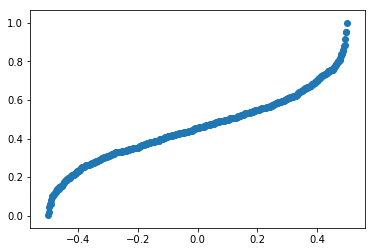

In [19]:
# 5折交叉验证, 这里使用了不变换的 y
from sklearn.cross_validation import train_test_split
x_now, y_now = xy_sortby_y[:, :-1], y_scl
x_train, x_test, y_train, y_test = train_test_split(x_now, y_now, random_state=1, test_size=0.2)
plt.scatter(np.linspace(-0.5, 0.5, 480), sorted(y_train))
plt.show()

In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
workflow = Pipeline([ ('xgbr', XGBRegressor())])
tuned_parameters = {
    'xgbr__learning_rate': np.array([0.015, 0.025, 0.05]), 
    'xgbr__gamma': np.array([0.05, 0.1, 0.3, 0.5, 0.7]),
    'xgbr__reg_alpha': np.array([0, 0.1, 0.5, 1.0]),
    'xgbr__reg_lambda': np.array([0.01, 0.1, 1.0]),
    'xgbr__max_depth': np.array([3, 5, 7, 9]),
    'xgbr__subsample': np.array([0.8, 0.9, 1.0]),
    'xgbr__colsample_bytree': np.array([0.7, 0.8, 0.9]), 
}
scores = ['neg_mean_squared_error', 'neg_mean_absolute_error']

D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [21]:
# XGBoost 回归 default
from xgboost import XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(x_train, y_train)
y_pred = xgbr.predict(x_test)
yh_rebuild = rebuild((y_pred), ymin, ymax)
ytest_rebuild = rebuild((y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MAE Error: ', mae_err)
print(xgbr.score(x_test, y_test))

XGBoost Regression MSE Error:  0.0417711681527
XGBoost Regression MAE Error:  0.162628226108
0.12046245711


In [ ]:
# # XGBoost 回归 MSE
# from xgboost import XGBRegressor
# xgbr_mse = XGBRegressor()
# xgbr_mse.fit(x_train, y_train)
# y_pred = xgbr_mse.predict(x_test)
# yh_rebuild = rebuild(gy(y_pred), ymin, ymax)
# ytest_rebuild = rebuild(gy(y_test), ymin, ymax)
# mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
# print('XGBoost Regression MSE Error: ', mse_err)
# mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
# print('XGBoost Regression MAE Error: ', mae_err)
# print(xgbr_mse.score(x_test, y_test))

In [22]:
# XGBoost 回归 MAE
from xgboost import XGBRegressor
xgbr_mae = XGBRegressor(learning_rate=0.05,
    gamma=0.05,
    reg_alpha=0.5,
    reg_lambda=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7
)
xgbr_mae.fit(x_train, y_train)
y_pred = xgbr_mae.predict(x_test)
yh_rebuild = rebuild((y_pred), ymin, ymax)
ytest_rebuild = rebuild((y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MAE Error: ', mae_err)
print(xgbr_mae.score(x_test, y_test))

XGBoost Regression MSE Error:  0.04116376863
XGBoost Regression MAE Error:  0.164945866661
0.133251928415


In [23]:
# XGBoost 回归 MAE
from xgboost import XGBRegressor
xgbr_mae = XGBRegressor(learning_rate=0.05,
    gamma=0.05,
    reg_alpha=0.5,
    reg_lambda=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7
)
xgbr_mae.fit(x_now, y_now)
y_pred = xgbr_mae.predict(x_test)
yh_rebuild = rebuild((y_pred), ymin, ymax)
ytest_rebuild = rebuild((y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MAE Error: ', mae_err)
print(xgbr_mae.score(x_test, y_test))

XGBoost Regression MSE Error:  0.0122963331043
XGBoost Regression MAE Error:  0.0876778603028
0.741087366809


In [33]:
# 超参数搜索后的模型 MAE
from sklearn.svm import SVR
model_svr_rbf_ = SVR(kernel='rbf', C=1.2915496650148841, gamma=0.01)
model_svr_rbf_.fit(x_train, y_train)
y_pred = model_svr_rbf_.predict(x_test)
yh_rebuild = rebuild((y_pred), ymin, ymax)
ytest_rebuild = rebuild((y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('Support Vector Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('Support Vector Regression MAE Error: ', mae_err)
print(model_svr_rbf_.score(x_test, y_test))

Support Vector Regression MSE Error:  0.039203138566
Support Vector Regression MAE Error:  0.159512729036
0.174535165533


In [31]:
# Summary 最终流程
# 保留列
remain_header = list(remain_column)
save_pickle('remain_header.bin', remain_header)
# 模型本体
save_pickle('pca.bin', est)
save_pickle('xgbr2.model.bin', xgbr_mae)
save_pickle('svr_rbf.model.bin', model_svr_rbf_)
# 反演函数
def gy(u): # g: u -> y
    a = 0.172020013840487
    b = 2.355955139758581
    c = 0.028332501141596
    d = 0.450477070771684
    return a * np.tan(b * u + c) + d
ys = [ymin, ymax]
save_pickle('ys.bin', ys)